## Machine Learning

* For the machine learning of this project, my aim is to predict PISA score averages given the features like GDP, world region, income level, expected school years, gender inequality etc.

* I will try different models, namely: K nearest neighbours, decision tree, XGBoost and linear regression. I will also try changing their parameters to see if I can get a lower MSE / RMSE.

* At the end I will compare these scores with each other to find the model that best predicts the PISA scores from my dataset.

In [7]:
#importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, LeaveOneOut, cross_val_predict

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error

# Settings
sns.set(style="whitegrid")


In [2]:
df = pd.read_csv('complete_data.csv')

# one hot encoding for income level classification, updated from recit 10
df_dummy = pd.get_dummies(df['classification'], prefix='classification', drop_first = False)

df = pd.concat([df, df_dummy], axis=1) # add encoded variables to original data frame

# one hot encoding for world reagions
df_dummy = pd.get_dummies(df['World_Region'], prefix='World_Region', drop_first = False)

df = pd.concat([df, df_dummy], axis=1)

df.to_csv("complete_data_encoded.csv")

* Catagorical variables are converted using one hot encoding.

  * Since I only have 4 income levels and 6 world regions, one hot encoding or dummy variable approach can be used. Label encoding could be better if there were too many catagories, but it is not the case here.

  * For regression models dummy variable approach can be used to have a meaningful intercept, but for other models (KNN, XGBoost...) I will use one hot encoding.


In [3]:
# unused columns for ML are dropped for clarity

#df now has all features and the target column, including encoded categorical variables
df = df.drop(columns=["Entity",
    "Year",
    "classification",
    "World_Region",
    "Population",

    "Math_PISA_Female",
    "Math_PISA_Male",
    "Math_PISA_Total",

    "Read_PISA_Female",
    "Read_PISA_Male",
    "Read_PISA_Total",

    "Sci_PISA_Female",
    "Sci_PISA_Male",
    "Sci_PISA_Total" ,


    'PISA_Girls_Average',
    'PISA_Boys_Average',

    'Mean_School_Years_M',
    'Mean_School_Years_F',
    'Unnamed: 0'])


df.dtypes

,0
EduSpend_GDP,float64
GDP_PPP_perCapita,float64
Gini_Coefficient,float64
Gender_Inequality,float64
GovEduSpend_Pct,float64
Avg_School_Years,float64
Expected_School_Years,float64
HDI,float64
Corruption_Index,float64
PISA_Total_Average,float64


* Data frame containing the features and target value is prepared.

In [4]:
dummyVar_cols = [
    "classification_Low-income countries",
    "classification_Lower-middle-income countries",
    "classification_Upper-middle-income countries",
    "classification_High-income countries",

    "World_Region_Asia",
    "World_Region_Europe",
    "World_Region_North America",
    "World_Region_Africa",
    "World_Region_Oceania",
    "World_Region_South America",]


pisa_before_std= df[['PISA_Total_Average']]

# creating a list of numerical columns to standardize, excluding encoded categorical variables
numerical_columns = []
for column in df.columns:
    if column not in dummyVar_cols:
      numerical_columns.append(column)

print(numerical_columns) # to check the column names

scaler = StandardScaler()

# only numerical columns are scaled
scaled_values = scaler.fit_transform(df[numerical_columns])

# partial data frame of scaled values with same column names
df_scaled = pd.DataFrame(scaled_values, columns=numerical_columns, index=df.index)

# scaled and encoded values are combined back, df is now rewritten with standardized values
df = pd.concat([ df_scaled, df[dummyVar_cols]], axis=1)


df = df * 1 # used to convert boolean to integer

df.head()
#df.describe()


['EduSpend_GDP', 'GDP_PPP_perCapita', 'Gini_Coefficient', 'Gender_Inequality', 'GovEduSpend_Pct', 'Avg_School_Years', 'Expected_School_Years', 'HDI', 'Corruption_Index', 'PISA_Total_Average']


,EduSpend_GDP,GDP_PPP_perCapita,Gini_Coefficient,Gender_Inequality,GovEduSpend_Pct,Avg_School_Years,Expected_School_Years,HDI,Corruption_Index,PISA_Total_Average,classification_Low-income countries,classification_Lower-middle-income countries,classification_Upper-middle-income countries,classification_High-income countries,World_Region_Asia,World_Region_Europe,World_Region_North America,World_Region_Africa,World_Region_Oceania,World_Region_South America
0,-0.856356,-1.068267,-0.763326,0.184493,-0.607354,-0.611713,-1.734980,-1.292986,1.340299,-1.229175,0,1,0,0,0,1,0,0,0,0
1,-1.078962,-1.016115,-0.595039,0.078031,-0.607354,-0.526086,-1.441734,-1.056468,1.357391,-1.161412,0,1,0,0,0,1,0,0,0,0
2,-1.038373,-0.957632,-0.731048,-0.040955,-0.757809,-0.442518,-0.929942,-0.778817,1.278768,-1.093649,0,1,0,0,0,1,0,0,0,0
3,-0.832733,-0.885472,-0.824459,-0.448015,-0.665533,-0.311499,-0.579946,-0.532016,1.394993,-1.025885,0,0,1,0,0,1,0,0,0,0
4,-0.948702,-0.847682,-0.932624,-0.416702,-0.543714,-0.064737,0.464697,-0.151531,1.425759,-0.841099,0,0,1,0,0,1,0,0,0,0


* All continues features are standardized, catagorical ones are one hot encoded.

In [5]:
#df = df. drop(columns = ["HDI"])

X = df.drop(columns = 'PISA_Total_Average') # all features are put into a new dataframe X
y = df['PISA_Total_Average'] # target value PISA_Total_Average is put into new dataframe y
# seperate dataframes to be used in ML models is now prepared

print(y.head())
X.head()

0   -1.229175
1   -1.161412
2   -1.093649
3   -1.025885
4   -0.841099
Name: PISA_Total_Average, dtype: float64


,EduSpend_GDP,GDP_PPP_perCapita,Gini_Coefficient,Gender_Inequality,GovEduSpend_Pct,Avg_School_Years,Expected_School_Years,HDI,Corruption_Index,classification_Low-income countries,classification_Lower-middle-income countries,classification_Upper-middle-income countries,classification_High-income countries,World_Region_Asia,World_Region_Europe,World_Region_North America,World_Region_Africa,World_Region_Oceania,World_Region_South America
0,-0.856356,-1.068267,-0.763326,0.184493,-0.607354,-0.611713,-1.734980,-1.292986,1.340299,0,1,0,0,0,1,0,0,0,0
1,-1.078962,-1.016115,-0.595039,0.078031,-0.607354,-0.526086,-1.441734,-1.056468,1.357391,0,1,0,0,0,1,0,0,0,0
2,-1.038373,-0.957632,-0.731048,-0.040955,-0.757809,-0.442518,-0.929942,-0.778817,1.278768,0,1,0,0,0,1,0,0,0,0
3,-0.832733,-0.885472,-0.824459,-0.448015,-0.665533,-0.311499,-0.579946,-0.532016,1.394993,0,0,1,0,0,1,0,0,0,0
4,-0.948702,-0.847682,-0.932624,-0.416702,-0.543714,-0.064737,0.464697,-0.151531,1.425759,0,0,1,0,0,1,0,0,0,0


### K-Nearest Neighbours

* If features are not standardized, then larger scaled values will affect the results more than the smaller scaled values when finding the nearest neighbours. Because of this reason standardized features are used for KNN.  

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"For k=5, KNN train-test split MSE:  {mse:.3f}")
print(f"For k=5, KNN train-test split RMSE: {rmse:.3f}")


For k=5, KNN train-test split MSE:  0.172
For k=5, KNN train-test split RMSE: 0.415


* First I tried choosing k=5 and 80-20% train test split, now I will apply leave one out and k fold for cross validation and try different k values to see if it improves the results.

> For k=5, KNN train-test split MSE:  0.172  
> For k=5, KNN train-test split RMSE: 0.415

* LOO requires more computation compared to K-Fold or train-test split. But my dataset is not exteremly big, so it does not take much time to compute for my application.

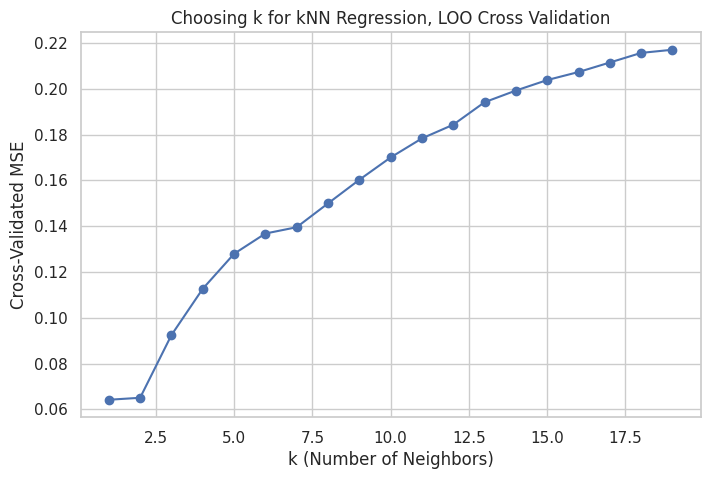

Best k: 1
MSE at best k: 0.064
RMSE at best k: 0.253


In [31]:
k_values = list(range(1, 20))
cv_scores = []
loo = LeaveOneOut()

for k in k_values:
  knn = KNeighborsRegressor(n_neighbors=k)

  scores = cross_val_score(knn, X, y, cv=loo, scoring='neg_mean_squared_error')
  cv_scores.append(-scores.mean())  # convert from negative MSE

# Plot k vs MSE, from recit 12
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Cross-Validated MSE")
plt.title("Choosing k for kNN Regression, LOO Cross Validation")
plt.grid(True)
plt.show()

best_index = np.argmin(cv_scores)
best_k = k_values[best_index]
best_mse   = cv_scores[best_index]
best_rmse  = np.sqrt(best_mse)

print(f"Best k: {best_k}")
print(f"MSE at best k: {best_mse:.3f}")
print(f"RMSE at best k: {best_rmse:.3f}")

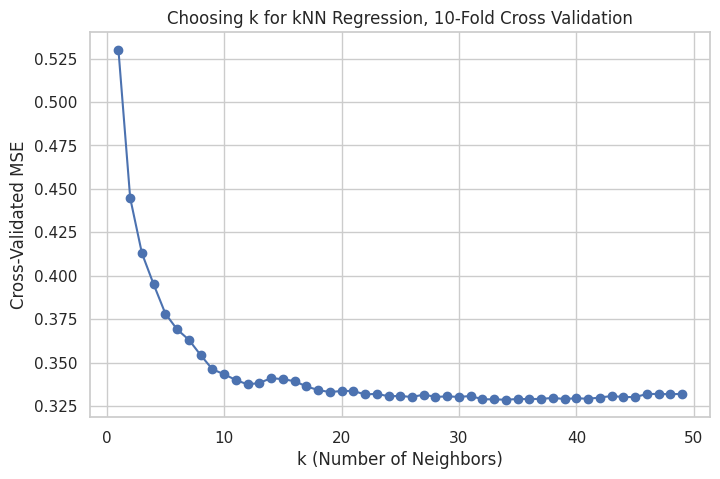

Best k: 34
MSE at best k: 0.329
RMSE at best k: 0.573




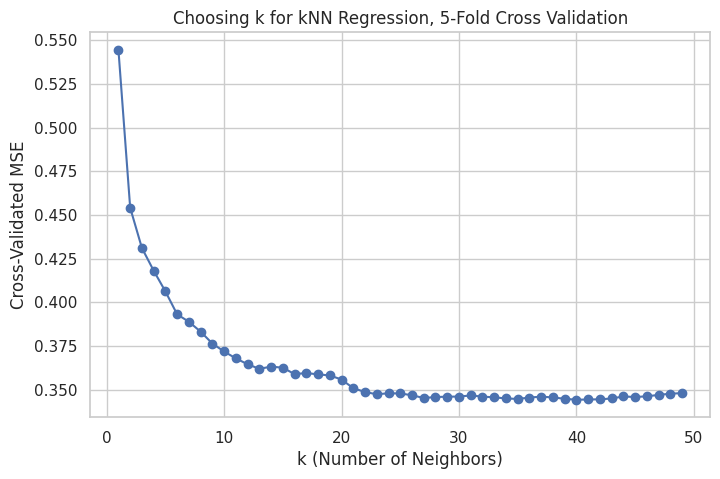

Best k: 40
MSE at best k: 0.344
RMSE at best k: 0.587


In [39]:
k_values = list(range(1, 50))
cv_scores = []

for k in k_values:
  knn = KNeighborsRegressor(n_neighbors=k)

  scores = cross_val_score(knn, X, y, cv=15, scoring='neg_mean_squared_error')
  cv_scores.append(-scores.mean())  # convert from negative MSE

# Plot k vs MSE, from recit 12
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Cross-Validated MSE")
plt.title("Choosing k for kNN Regression, 10-Fold Cross Validation")
plt.grid(True)
plt.show()

best_index = np.argmin(cv_scores)
best_k = k_values[best_index]
best_mse   = cv_scores[best_index]
best_rmse  = np.sqrt(best_mse)

print(f"Best k: {best_k}")
print(f"MSE at best k: {best_mse:.3f}")
print(f"RMSE at best k: {best_rmse:.3f}")
print()
print()

k_values = list(range(1, 50))
cv_scores = []

for k in k_values:
  knn = KNeighborsRegressor(n_neighbors=k)

  scores = cross_val_score(knn, X, y, cv=5, scoring='neg_mean_squared_error')
  cv_scores.append(-scores.mean())  # convert from negative MSE

# Plot k vs MSE, from recit 12
plt.figure(figsize=(8, 5))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Cross-Validated MSE")
plt.title("Choosing k for kNN Regression, 5-Fold Cross Validation")
plt.grid(True)
plt.show()

best_index = np.argmin(cv_scores)
best_k = k_values[best_index]
best_mse   = cv_scores[best_index]
best_rmse  = np.sqrt(best_mse)

print(f"Best k: {best_k}")
print(f"MSE at best k: {best_mse:.3f}")
print(f"RMSE at best k: {best_rmse:.3f}")

## Decision Tree

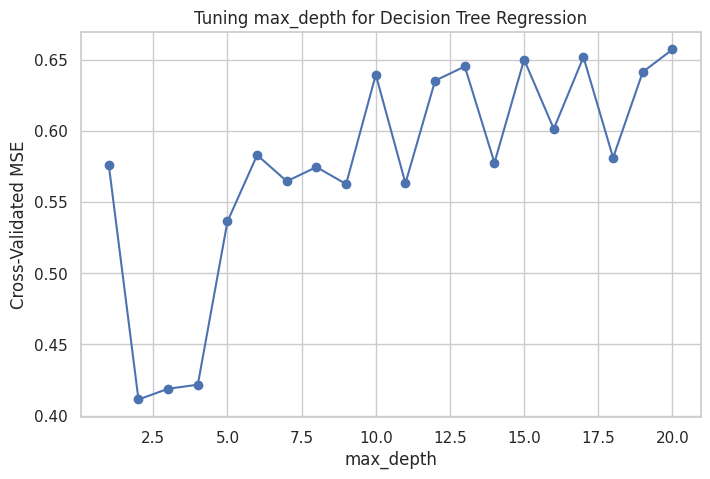

Best max_depth: 2
MSE at best depth: 0.411
RMSE at best depth: 0.641


In [40]:
depths = list(range(1, 21))
cv_scores = []

# updated from recit 12
for d in depths:
    tree = DecisionTreeRegressor(max_depth=d, random_state=1)
    scores = cross_val_score(tree, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())

# Plot
plt.figure(figsize=(8, 5))
plt.plot(depths, cv_scores, marker='o')
plt.xlabel("max_depth")
plt.ylabel("Cross-Validated MSE")
plt.title("Tuning max_depth for Decision Tree Regression")
plt.grid(True)
plt.show()

best_index = np.argmin(cv_scores)

best_depth = depths[best_index]
best_mse   = cv_scores[best_index]
best_rmse  = np.sqrt(best_mse)

print(f"Best max_depth: {best_depth}")
print(f"MSE at best depth: {best_mse:.3f}")
print(f"RMSE at best depth: {best_rmse:.3f}")


* Here is a decision tree with min_samples_leaf = 1, and mean_samples_split = 2.

* With these hyperparameters best max_depth = 2.  
 > MSE = 0.411  
 RMSE = 0.641

* I will now try different split and leaf sizes to see if they will improve the predictions.

---

Best hyperparameters found:
  max_depth        = 9
  min_samples_split= 2
  min_samples_leaf = 8
5-fold CV MSE      = 0.192
5-fold CV RMSE     = 0.439


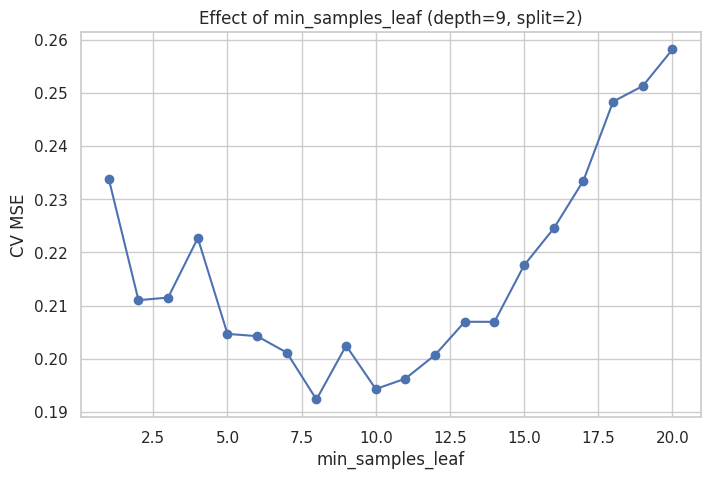

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# different values for max_depth, min_samples_split and min_samples_leaf will be tried to find the best one
depths = list(range(1, 21))
splits = list(range(2, 21)) # splits should be at least 2
leafs = list(range(1, 21))

results = []

cv = KFold(n_splits=5, shuffle=True, random_state=1)

for s in splits:
  for l in leafs:
    for d in depths:
      tree = DecisionTreeRegressor(
                max_depth=d,
                min_samples_split=s,
                min_samples_leaf=l,
                random_state=1
            )

      scores = cross_val_score(tree, X, y, cv=cv, scoring='neg_mean_squared_error')
      mean_mse = -scores.mean()

      # appending leaf, depth and split number with mean_mse to results list,
      # later it will be compared to find the best
      results.append((d, s, l, mean_mse))


best_depth = -1
best_split = -1
best_leaf  = -1
best_mse   = float('inf')  # to start with +∞

for entry in results:
    d, s, l, mse = entry
    if mse < best_mse:
        best_mse   = mse
        best_depth = d
        best_split = s
        best_leaf  = l

print("Best hyperparameters found:")
print("  max_depth        =", best_depth)
print("  min_samples_split=", best_split)
print("  min_samples_leaf =", best_leaf)
print(f"5-fold CV MSE      = {best_mse:.3f}")
print(f"5-fold CV RMSE     = {np.sqrt(best_mse):.3f}")

# ploting MSE vs leaf size at the best depth and split
leaf_sizes = []
mses       = []

for entry in results:
    d, s, l, mse = entry
    if d == best_depth and s == best_split:
        leaf_sizes.append(l)
        mses.append(mse)

plt.figure(figsize=(8,5))
plt.plot(leaf_sizes, mses, marker='o')
plt.xlabel('min_samples_leaf')
plt.ylabel('CV MSE')
plt.title(f'Effect of min_samples_leaf (depth={best_depth}, split={best_split})')
plt.grid(True)
plt.show()


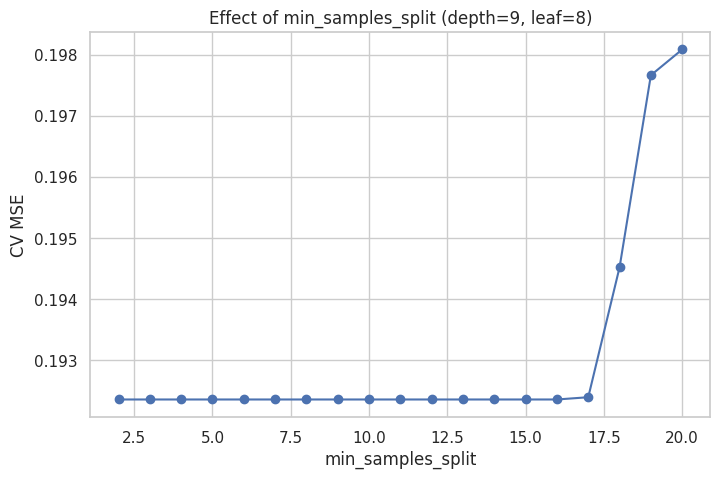

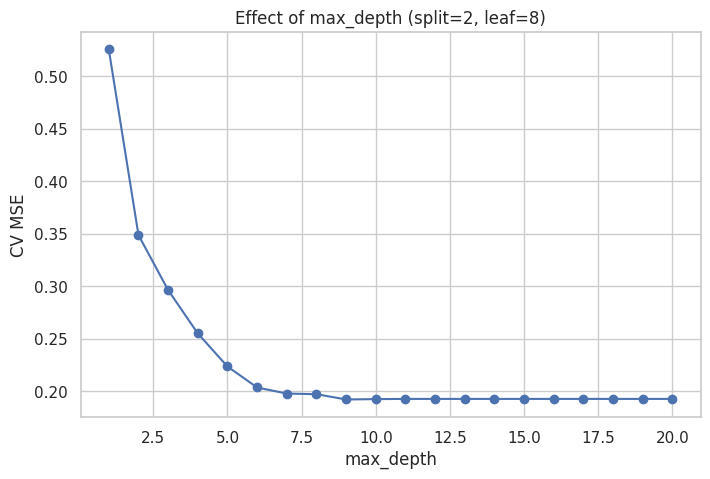

In [ ]:
# Plot MSE vs min_samples_split at the best depth and leaf
split_sizes = []
mses_split = []
for d, s, l, mse in results:
    if d == best_depth and l == best_leaf:
        split_sizes.append(s)
        mses_split.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(split_sizes, mses_split, marker='o')
plt.xlabel('min_samples_split')
plt.ylabel('CV MSE')
plt.title(f'Effect of min_samples_split (depth={best_depth}, leaf={best_leaf})')
plt.grid(True)
plt.show()

# Plot MSE vs max_depth at the best split and leaf
depths_list = []
mses_depth = []
for d, s, l, mse in results:
    if s == best_split and l == best_leaf:
        depths_list.append(d)
        mses_depth.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(depths_list, mses_depth, marker='o')
plt.xlabel('max_depth')
plt.ylabel('CV MSE')
plt.title(f'Effect of max_depth (split={best_split}, leaf={best_leaf})')
plt.grid(True)
plt.show()

* I tried different max_depth, min_samples_split, min_sampes_leaf values. So I opted out to use k-fold to do cross validation and k=5. As this will also give a good result and will not be as computationally costly as LOO.

* From the graphs, it is clear that best values are within the given range, so I will not try larger values.

>    For min_samples_leaf, MSE first decreases and then it starts to increase after some point. From these low values valley lowest one is chosen.

>    For min_samples_split increasing the splits does not yield to a visibly lower MSE up to ~17 and then it starts to significantly increse. From that best value is found to be 2.

>  For the max_depth it starts with high MSE and decreses as max_depth increses. But incresing max_depth too much overcomplicates the model. Therefore max_depth = 9 is chosen right after the significant drop.


 After the calculations, these are the best hyperparameters found:  
> * max_depth        = 9   
* min_samples_split= 2  
* min_samples_leaf = 8  
* 5-fold CV MSE      = 0.192  
* 5-fold CV RMSE     = 0.439  

* When comparing this result to my first trial with 80-20 train test split and default split and leaf sizes:
 * MSE is dropped from 0.411 to 0.192
 * RMSE is dropped from 0.641 to 0.439

* From these results, it is seen that tweaking the hyperparameters improves the models predictions.

## XGBoost

## Linear regression

### Converting Categorical Variables

In [47]:
# dropping a column from one hot encoding to get dummy variable

# dummy variable approach for income level classification
df = df.drop(columns=['classification_High-income countries'])

# dummy variable approach for world regions
# I chose to drop World_Region_North America specifically because it had a high VIF score
df = df.drop(columns=['World_Region_North America'])

df.to_csv("complete_data_dummy.csv")


* Previously, when I prepared my data I used one hot encoding to use for other models.

* For linear regression, intercept is important so I will drop one of the columns for each catagorical variable and get dummy variable instead of one hot encoding.

In [48]:
df = df * 1 # used to convert boolean to integer,
            # it will be useful later when calculating VIF for dummy variable encoded columns

df.head()

,EduSpend_GDP,GDP_PPP_perCapita,Gini_Coefficient,Gender_Inequality,GovEduSpend_Pct,Avg_School_Years,Expected_School_Years,HDI,Corruption_Index,PISA_Total_Average,classification_Low-income countries,classification_Lower-middle-income countries,classification_Upper-middle-income countries,World_Region_Asia,World_Region_Europe,World_Region_Africa,World_Region_Oceania,World_Region_South America
0,-0.856356,-1.068267,-0.763326,0.184493,-0.607354,-0.611713,-1.734980,-1.292986,1.340299,-1.229175,0,1,0,0,1,0,0,0
1,-1.078962,-1.016115,-0.595039,0.078031,-0.607354,-0.526086,-1.441734,-1.056468,1.357391,-1.161412,0,1,0,0,1,0,0,0
2,-1.038373,-0.957632,-0.731048,-0.040955,-0.757809,-0.442518,-0.929942,-0.778817,1.278768,-1.093649,0,1,0,0,1,0,0,0
3,-0.832733,-0.885472,-0.824459,-0.448015,-0.665533,-0.311499,-0.579946,-0.532016,1.394993,-1.025885,0,0,1,0,1,0,0,0
4,-0.948702,-0.847682,-0.932624,-0.416702,-0.543714,-0.064737,0.464697,-0.151531,1.425759,-0.841099,0,0,1,0,1,0,0,0


* Standardization was already applied to continuous variables including target variable, dummy variable encoded ones are exempt.

* Boolean values are converted to integer 0 and 1 for calculating VIF in later cells.

### Checking for Multicollinearity

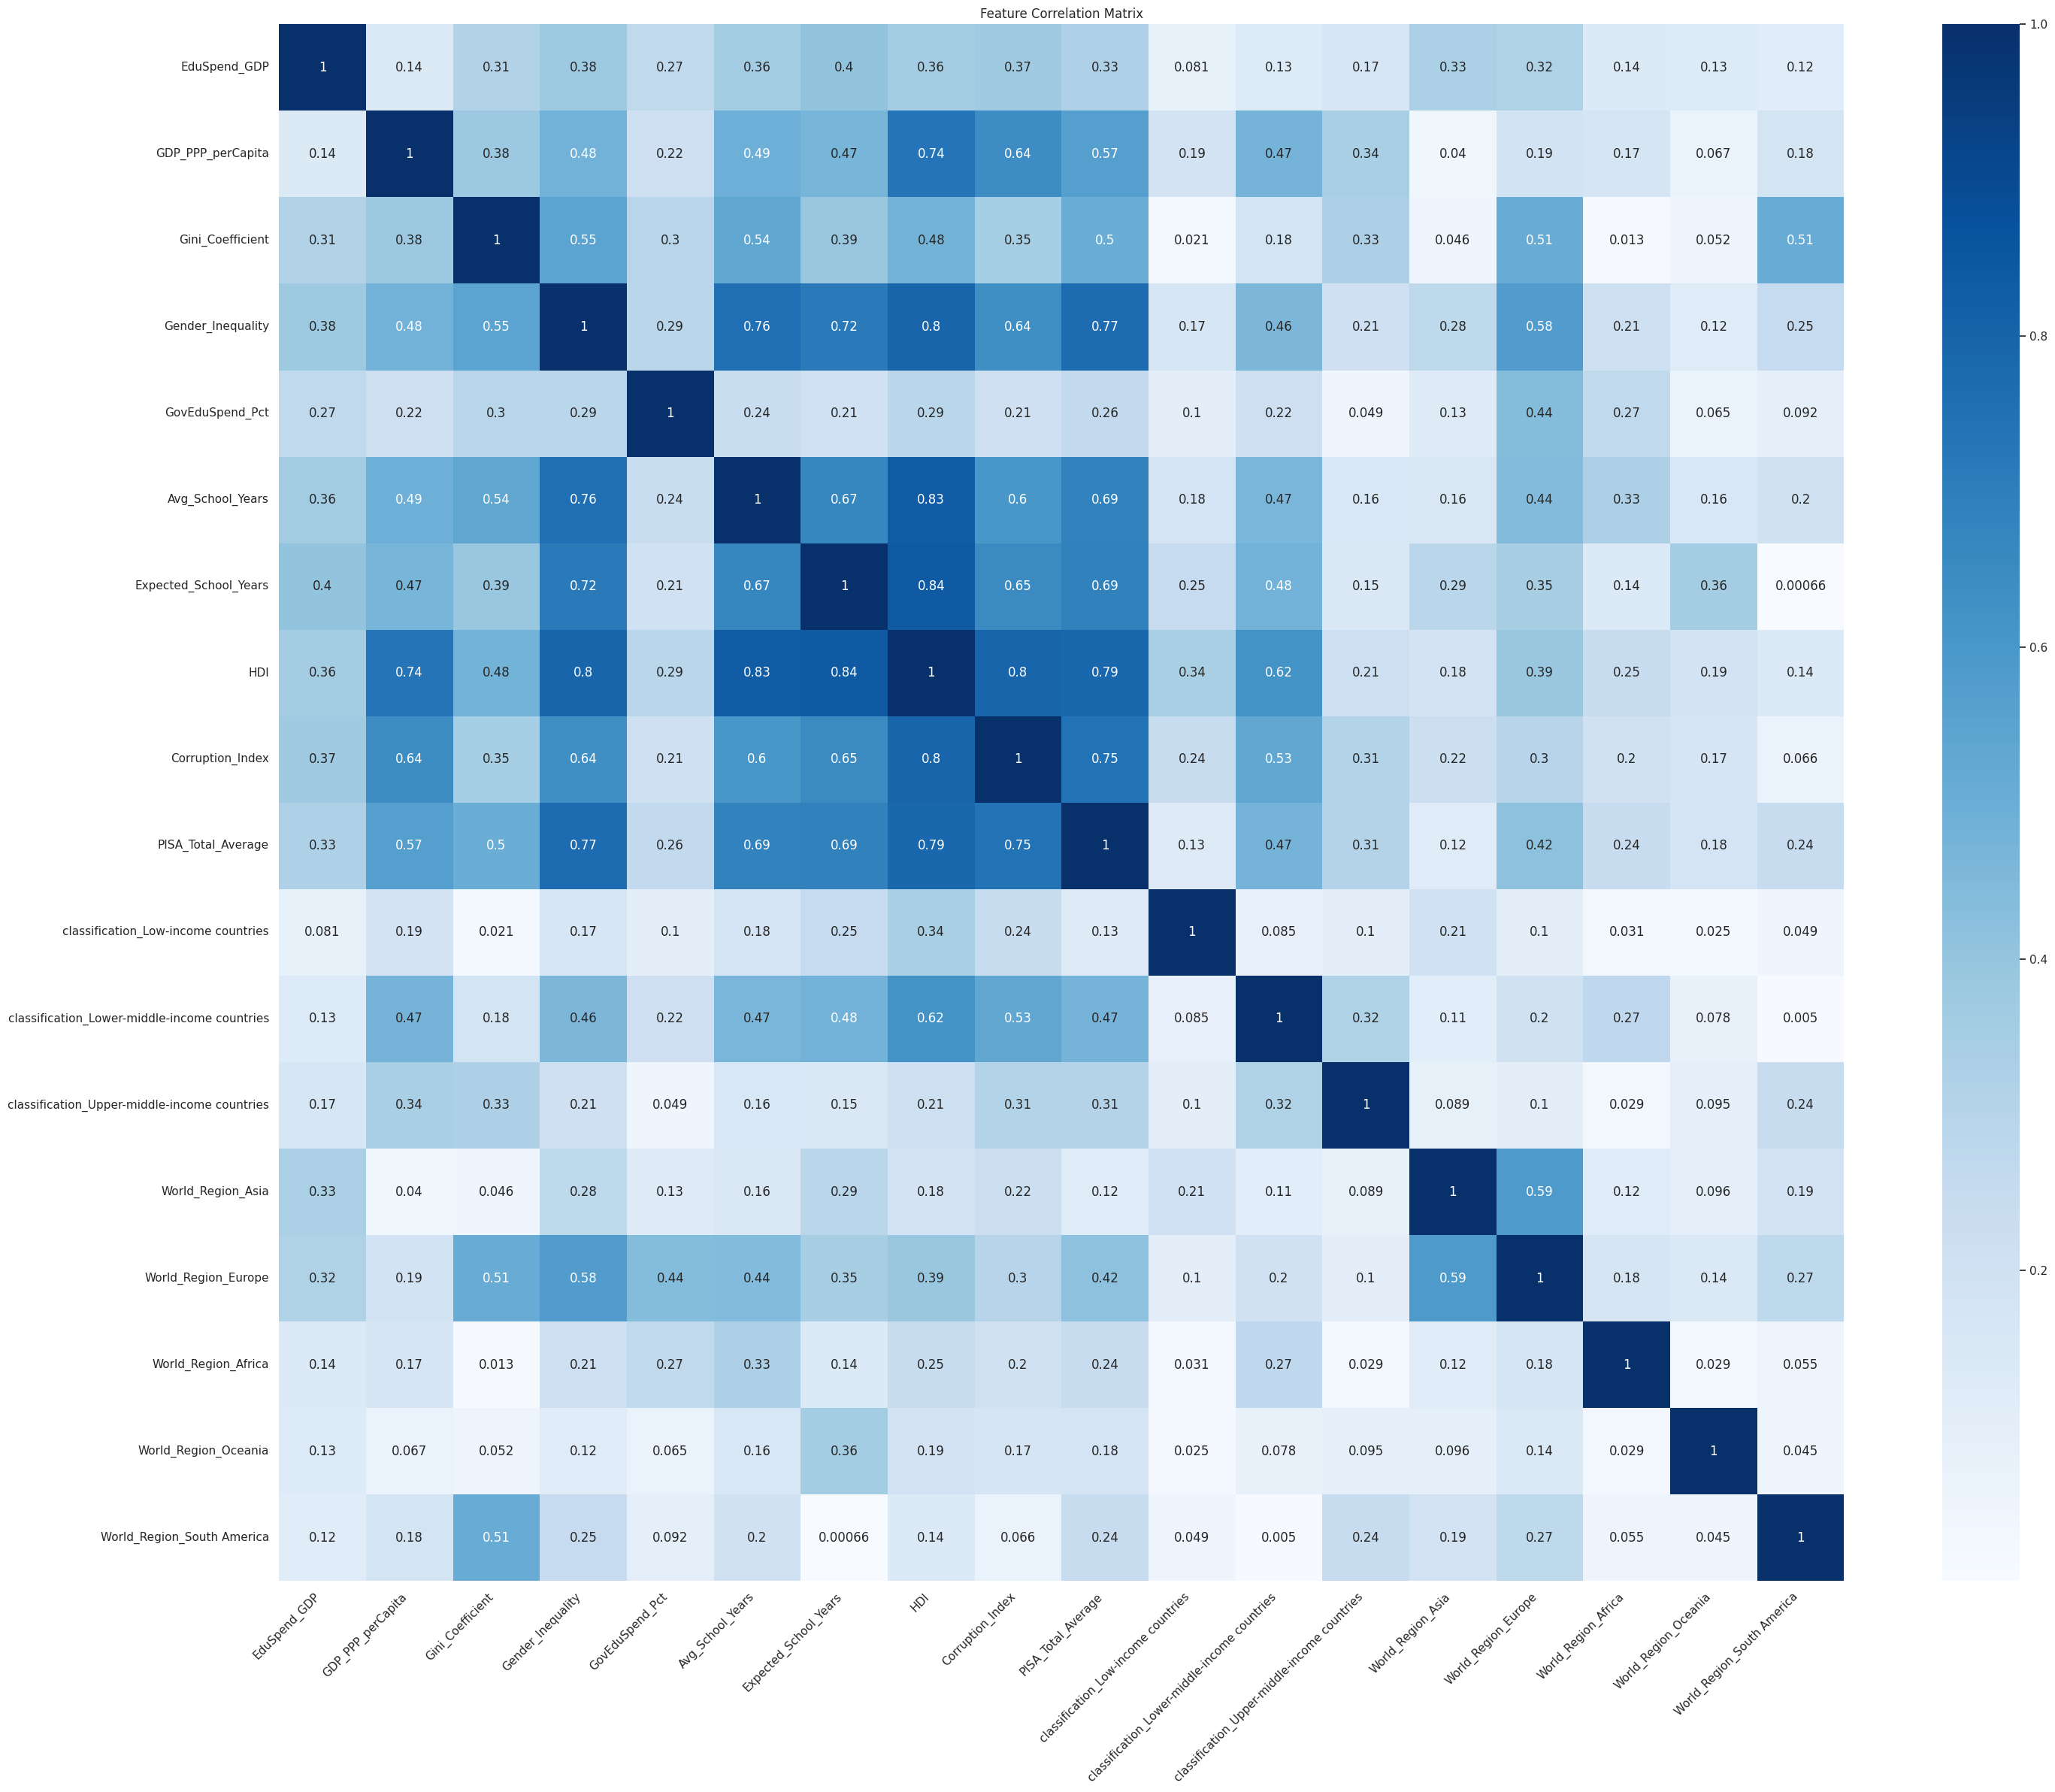

In [80]:
import seaborn as sns

# color palette to make both +1 and -1 correlation red, 0 white
# it is to see correlation more clearly by looking at the darkness regardless of them being positive or negative correlation

corr = df.corr().abs() # converted to absolute value to have higher correlations (negative or positive) more visible

plt.figure(figsize=(30, 24))

sns.heatmap(
    corr,
    annot=True,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    cmap="Blues"

)


plt.title("Feature Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks()
plt.tight_layout()

plt.show()


* Since I am looking for multicollinearity, I converted correlations to absolute value to see it more clearly from the graph.

* From the correlation matrix pairwise correlations are below 0.8 except for HDI, so they seem acceptable.

* Now I will look at VIF to see more clearly if there is multicollinarity.

In [52]:
df_multicol = df.drop(columns=['PISA_Total_Average'])
# Calculate VIF
X = df_multicol
X = sm.add_constant(X)  # statsmodels requires adding constant manually

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,feature,VIF
0,const,20.233552
1,EduSpend_GDP,2.060300
2,GDP_PPP_perCapita,3.786529
3,Gini_Coefficient,3.292586
4,Gender_Inequality,4.243949
5,GovEduSpend_Pct,1.946091
6,Avg_School_Years,6.322933
7,Expected_School_Years,6.489518
8,HDI,34.099189
9,Corruption_Index,3.657281


* From VIF results, every other column is below 10 while HDI is quite high with 34.1.

* I tried combining with other columns but VIF was still high, best approach seems to be dropping HDI column that is why I will drop and calculate VIF again.

In [53]:
df_multicol = df_multicol.drop(columns=[
    'HDI'
  ])

# Calculate VIF
X = df_multicol
X = sm.add_constant(X)  # statsmodels requires adding constant manually
X = X.drop(columns='const') # dropping const since it will not be usefull

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

#df_multicol.head()


,feature,VIF
0,EduSpend_GDP,2.032628
1,GDP_PPP_perCapita,2.525176
2,Gini_Coefficient,2.739586
3,Gender_Inequality,3.917655
4,GovEduSpend_Pct,1.872258
5,Avg_School_Years,3.230639
6,Expected_School_Years,3.551761
7,Corruption_Index,3.140862
8,classification_Low-income countries,1.761095
9,classification_Lower-middle-income countries,4.681397


* VIF are all below 5, therefore checking for multicollinearity is finished here.

---


### Applying Linear Regression

In [54]:
df_multicol.head()

,EduSpend_GDP,GDP_PPP_perCapita,Gini_Coefficient,Gender_Inequality,GovEduSpend_Pct,Avg_School_Years,Expected_School_Years,Corruption_Index,classification_Low-income countries,classification_Lower-middle-income countries,classification_Upper-middle-income countries,World_Region_Asia,World_Region_Europe,World_Region_Africa,World_Region_Oceania,World_Region_South America
0,-0.856356,-1.068267,-0.763326,0.184493,-0.607354,-0.611713,-1.734980,1.340299,0,1,0,0,1,0,0,0
1,-1.078962,-1.016115,-0.595039,0.078031,-0.607354,-0.526086,-1.441734,1.357391,0,1,0,0,1,0,0,0
2,-1.038373,-0.957632,-0.731048,-0.040955,-0.757809,-0.442518,-0.929942,1.278768,0,1,0,0,1,0,0,0
3,-0.832733,-0.885472,-0.824459,-0.448015,-0.665533,-0.311499,-0.579946,1.394993,0,0,1,0,1,0,0,0
4,-0.948702,-0.847682,-0.932624,-0.416702,-0.543714,-0.064737,0.464697,1.425759,0,0,1,0,1,0,0,0


* Feature columns are displayed.

---

Validation Set MSE: 0.293
Validation Set RMSE: 0.541


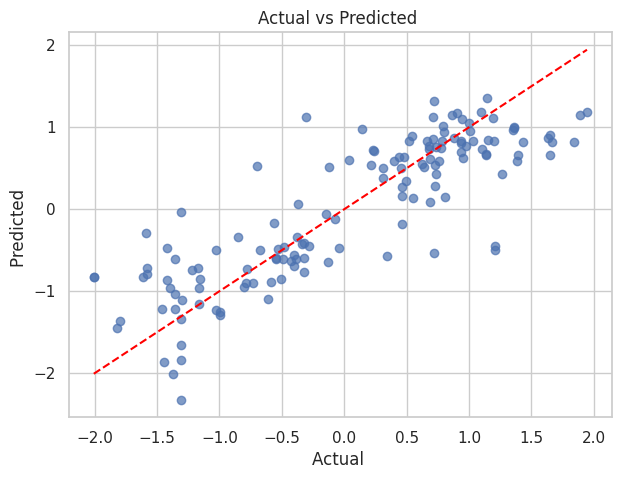

In [71]:
# updated from recitation 11 codes
X = df_multicol
y = df['PISA_Total_Average']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Train and evaluate
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Validation Set MSE: {mse:.3f}")
print(f"Validation Set RMSE: {mse**0.5:.3f}")



# Plot actual vs predicted scores
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel('Actual ')
plt.ylabel('Predicted ')
plt.title('Actual vs Predicted ')
plt.grid(True)
plt.show()

In [72]:
# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=55)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Convert negative MSE to positive
cv_mse_scores = -cv_scores

print("5-Fold CV MSE Scores:", cv_mse_scores)
print(f"Average CV MSE: {cv_mse_scores.mean():.3f}")
rmse = cv_mse_scores.mean()**0.5
print(f"Average CV RMSE: {rmse:.3f}")

5-Fold CV MSE Scores: [0.24605539 0.24839748 0.29527574 0.30576158 0.27827798]
Average CV MSE: 0.275
Average CV RMSE: 0.524


In [73]:
# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
cv_scores_loo = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')

# Convert to positive MSE
mse_loo = -cv_scores_loo
print(f"Average LOOCV MSE: {mse_loo.mean():.3f}")
print(f"Average LOOCV RMSE: {mse_loo.mean()**0.5:.3f}")

Average LOOCV MSE: 0.272
Average LOOCV RMSE: 0.522


* LOO and K-fold has less error compared to dividing data into into 80-20% train test data.

* LOO also has slightly less MSE and RMSE compared to 5-fold cross validation scores.
 * Since LOO uses more of the data it is reasonable that it results in better predictions. Though difference is not much here.

Train-test:
> Validation Set MSE: 0.246   
Validation Set RMSE: 0.496

LOO:
> MSE: 0.272  
RMSE: 0.522

5-fold:
> MSE: 0.275  
RMSE: 0.524